# DSCA Project | Used Cars Price Prediction

#### Maxim Lichko<br>Data Science and Business Analytics<br>May 2025

In [326]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

pd.set_option('display.precision', 2)

<br>

### 1. Dataset description

The dataset that is used for the model consists of 16 columns (15 features and selling price) and 558.837 records of patients data.
The dataset could be found on [Kaggle](https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data/data).

#### Problem overview

Optimized pricing strategies can be achieved by using predictive models that help dealerships understand the best prices for vehicles based on key factors such as condition, mileage, market trends, and consumer demand. These models enable dynamic pricing adjustments in real-time, ensuring competitiveness and maximizing profitability in a changing market landscape.

Enhanced market understanding is made possible by analyzing trends within the dataset, allowing businesses to track pricing patterns, consumer preferences, and shifts in demand over time. This analysis also helps identify the features and attributes of vehicles that lead to higher sales, providing valuable insights for inventory decisions and targeted marketing efforts.

#### Feature Descriptions

| **Name**         | **Description**                                                                 |
|-------------------|---------------------------------------------------------------------------------|
| **year**         | The manufacturing year of the vehicle.                                         |
| **make**         | The brand or manufacturer of the vehicle.                                      |
| **model**        | The specific model of the vehicle.                                             |
| **trim**         | Additional designation for the vehicle model.                                  |
| **body**         | The body type of the vehicle (e.g., SUV, Sedan).                               |
| **transmission** | The type of transmission in the vehicle (e.g., automatic).                     |
| **vin**          | Vehicle Identification Number, a unique code for each vehicle.                 |
| **state**        | The state where the vehicle is registered.                                     |
| **condition**    | Condition of the vehicle, possibly rated on a scale.                          |
| **odometer**     | The mileage or distance traveled by the vehicle.                               |
| **color**        | Exterior color of the vehicle.                                                 |
| **interior**     | Interior color of the vehicle.                                                 |
| **seller**       | The entity selling the vehicle.                                                |
| **mmr**          | Manheim Market Report, possibly indicating the estimated market value of the vehicle. |
| **sellingprice** | The price at which the vehicle was sold.                                        |
| **saledate**     | The date and time when the vehicle was sold.                                   |

In [329]:
df = pd.read_csv('Data/car_prices.csv')
df.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)


In [330]:
df['body'] = df['body'].str.lower()

df['saledate_parsed'] = pd.to_datetime(df['saledate'].str[:-15], format="%a %b %d %Y %H:%M:%S")
df['saledate_year'] = df['saledate_parsed'].dt.year.astype('object')
df['saledate_month'] = df['saledate_parsed'].dt.month.astype('object')

In [331]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   year             558837 non-null  int64         
 1   make             548536 non-null  object        
 2   model            548438 non-null  object        
 3   trim             548186 non-null  object        
 4   body             545642 non-null  object        
 5   transmission     493485 non-null  object        
 6   vin              558833 non-null  object        
 7   state            558837 non-null  object        
 8   condition        547017 non-null  float64       
 9   odometer         558743 non-null  float64       
 10  color            558088 non-null  object        
 11  interior         558088 non-null  object        
 12  seller           558837 non-null  object        
 13  mmr              558799 non-null  float64       
 14  sellingprice     558

In [332]:
df.isnull().sum()

year                   0
make               10301
model              10399
trim               10651
body               13195
transmission       65352
vin                    4
state                  0
condition          11820
odometer              94
color                749
interior             749
seller                 0
mmr                   38
sellingprice          12
saledate              12
saledate_parsed       38
saledate_year         38
saledate_month        38
dtype: int64

In [333]:
df = df.dropna()

In [335]:
df.isnull().sum()

year               0
make               0
model              0
trim               0
body               0
transmission       0
vin                0
state              0
condition          0
odometer           0
color              0
interior           0
seller             0
mmr                0
sellingprice       0
saledate           0
saledate_parsed    0
saledate_year      0
saledate_month     0
dtype: int64

In [338]:
df.describe()

,year,condition,odometer,mmr,sellingprice,saledate_parsed
count,472325.00,472325.00,472325.00,472325.00,472325.00,472325
mean,2010.21,30.77,66701.73,13837.06,13690.51,2015-03-07 09:14:26.400889600
min,1990.00,1.00,1.00,25.00,1.00,2014-01-01 09:15:00
25%,2008.00,24.00,28137.00,7425.00,7200.00,2015-01-22 01:30:00
50%,2012.00,35.00,51085.00,12300.00,12200.00,2015-02-17 01:30:00
75%,2013.00,41.00,96590.00,18300.00,18200.00,2015-05-21 06:00:00
max,2015.00,49.00,999999.00,182000.00,230000.00,2015-07-21 02:30:00
std,3.82,13.29,51939.59,9532.23,9613.03,NaN


In [340]:
del df['mmr']
del df['vin']

<br>

### 2. EDA

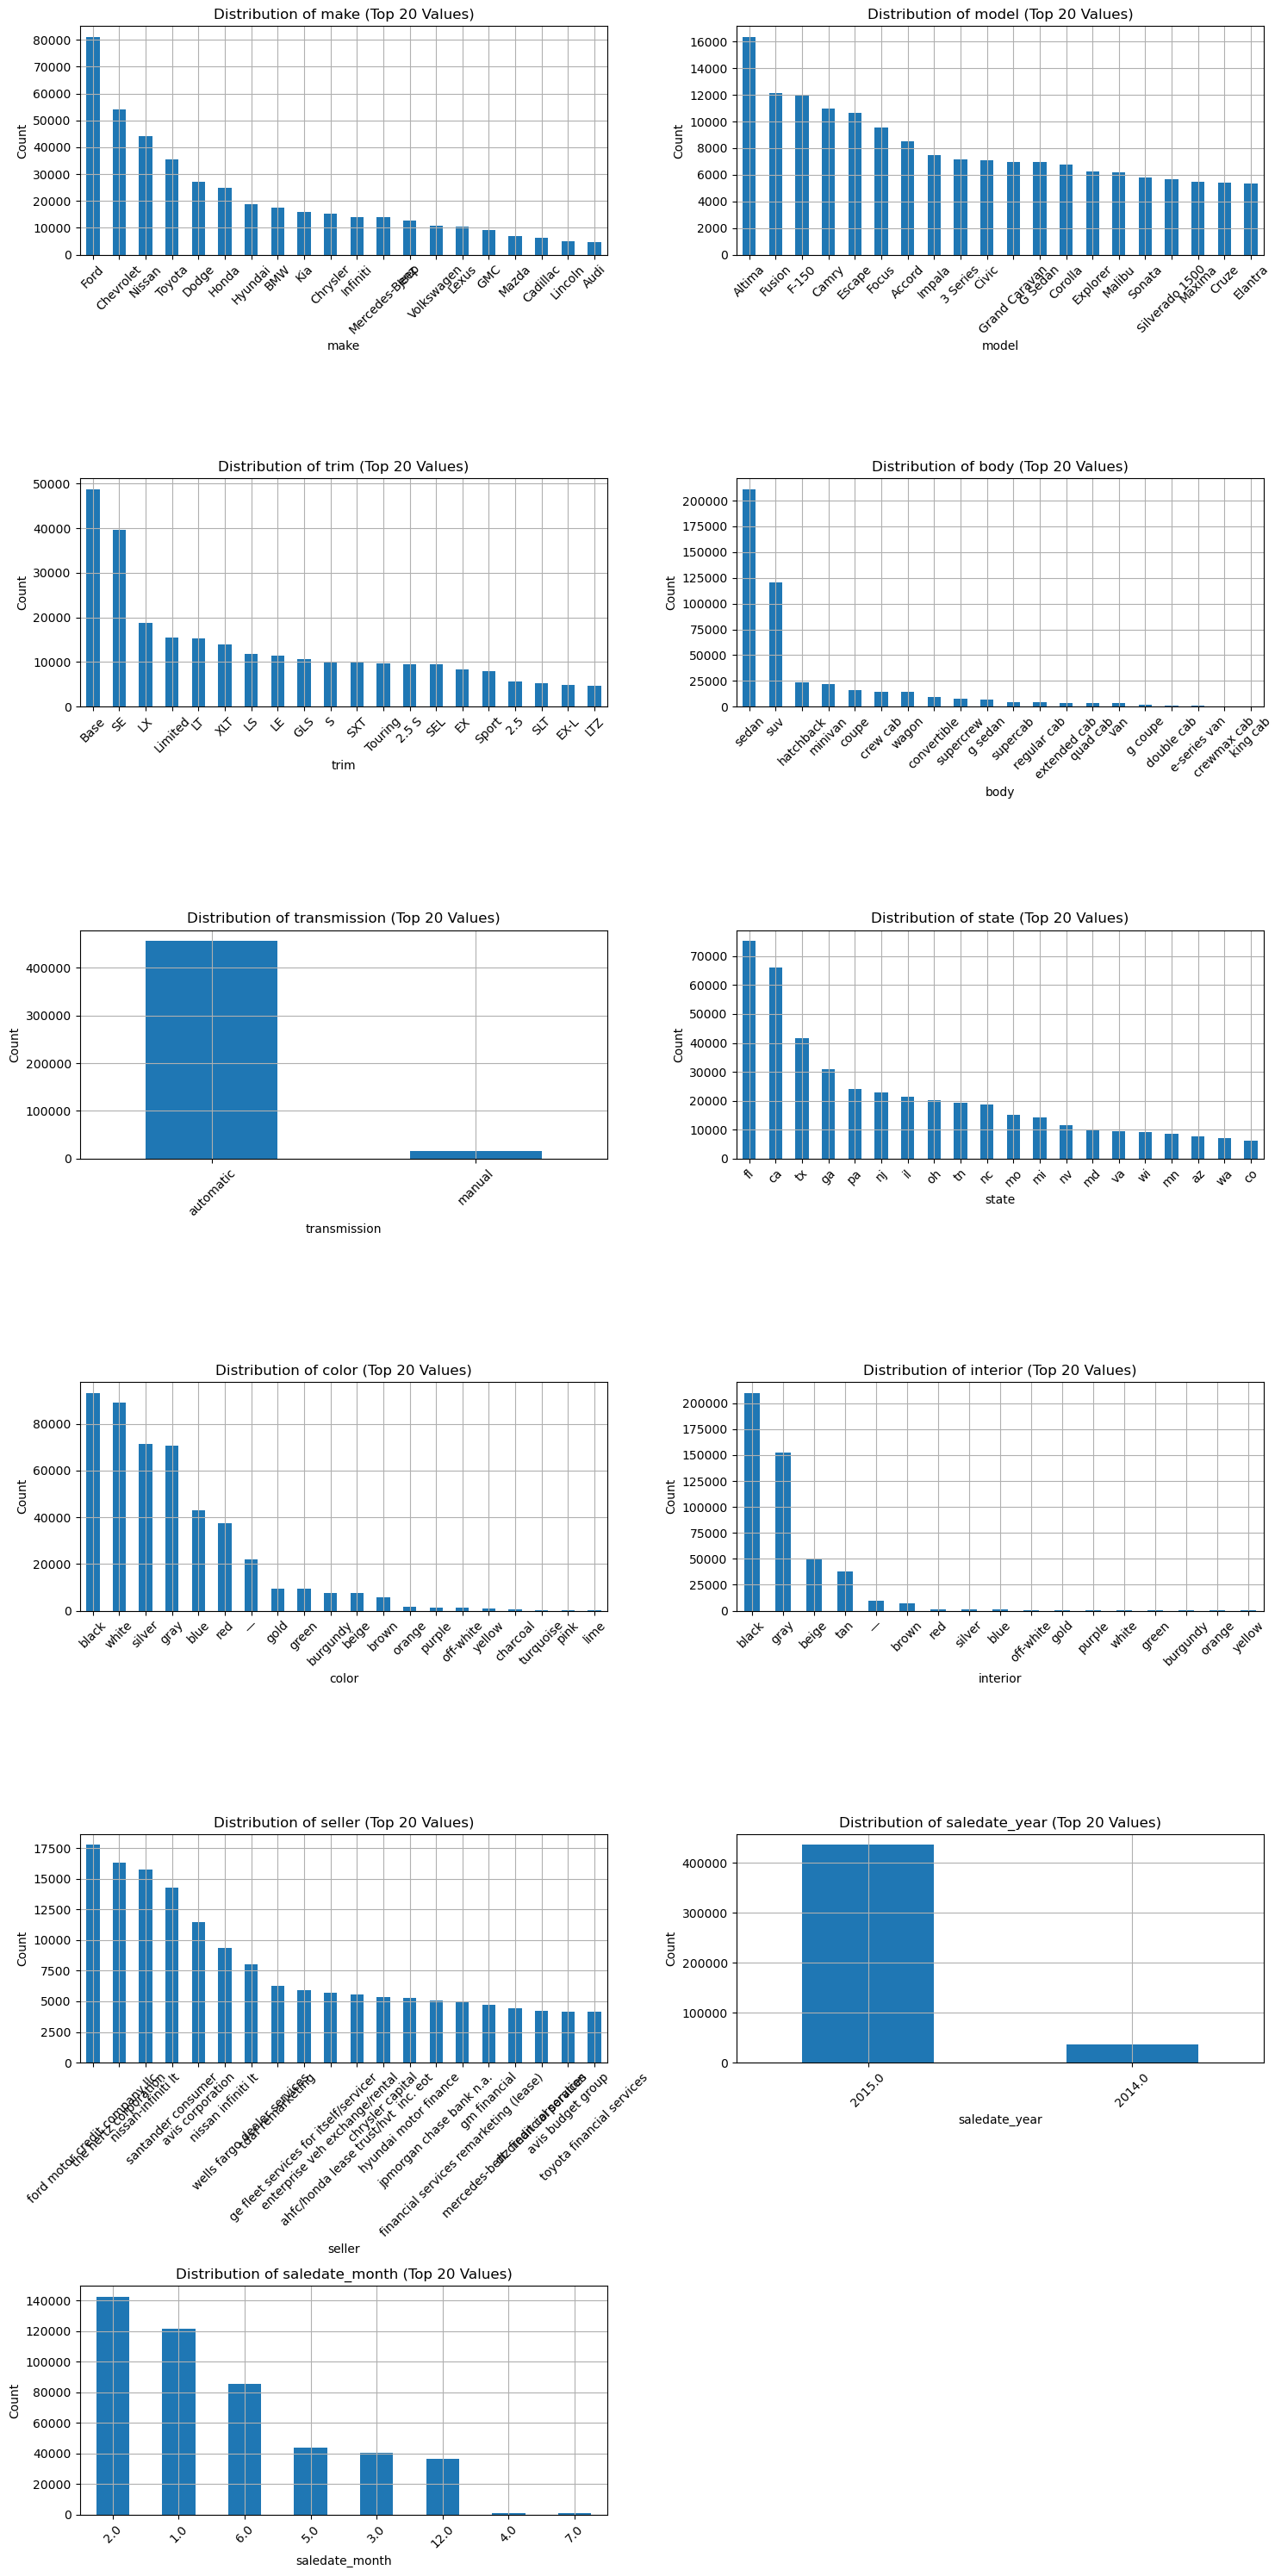

In [346]:
object_columns = [
    'make',
    'model',
    'trim',
    'body',
    'transmission',
    'state',
    'color',
    'interior',
    'seller',
    'saledate_year',
    'saledate_month'
]

n_cols = 2
n_rows = (len(object_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(object_columns):
    value_counts = df[col].dropna().value_counts().head(20)
    value_counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribution of {col} (Top 20 Values)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)

for j in range(len(object_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

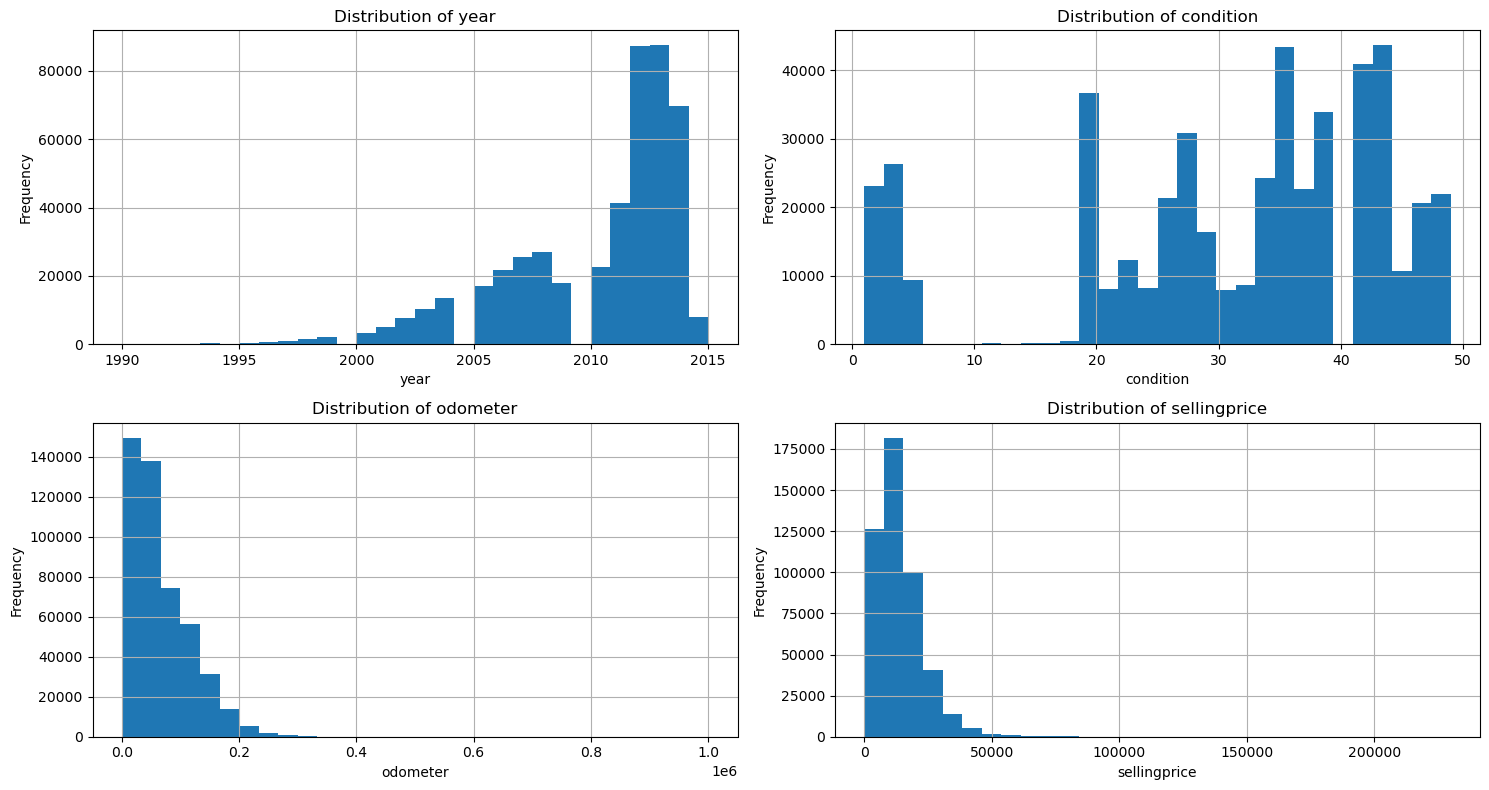

In [347]:
numerical_columns = ['year', 'condition', 'odometer', 'sellingprice']

n_cols = 2
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    df[col].dropna().hist(bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

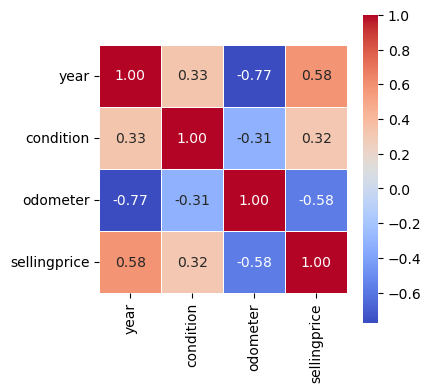

In [348]:
corr_matrix = df[['year', 'condition', 'odometer', 'sellingprice']].corr()

plt.figure(figsize=(4, 4))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True, linewidths=.5)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

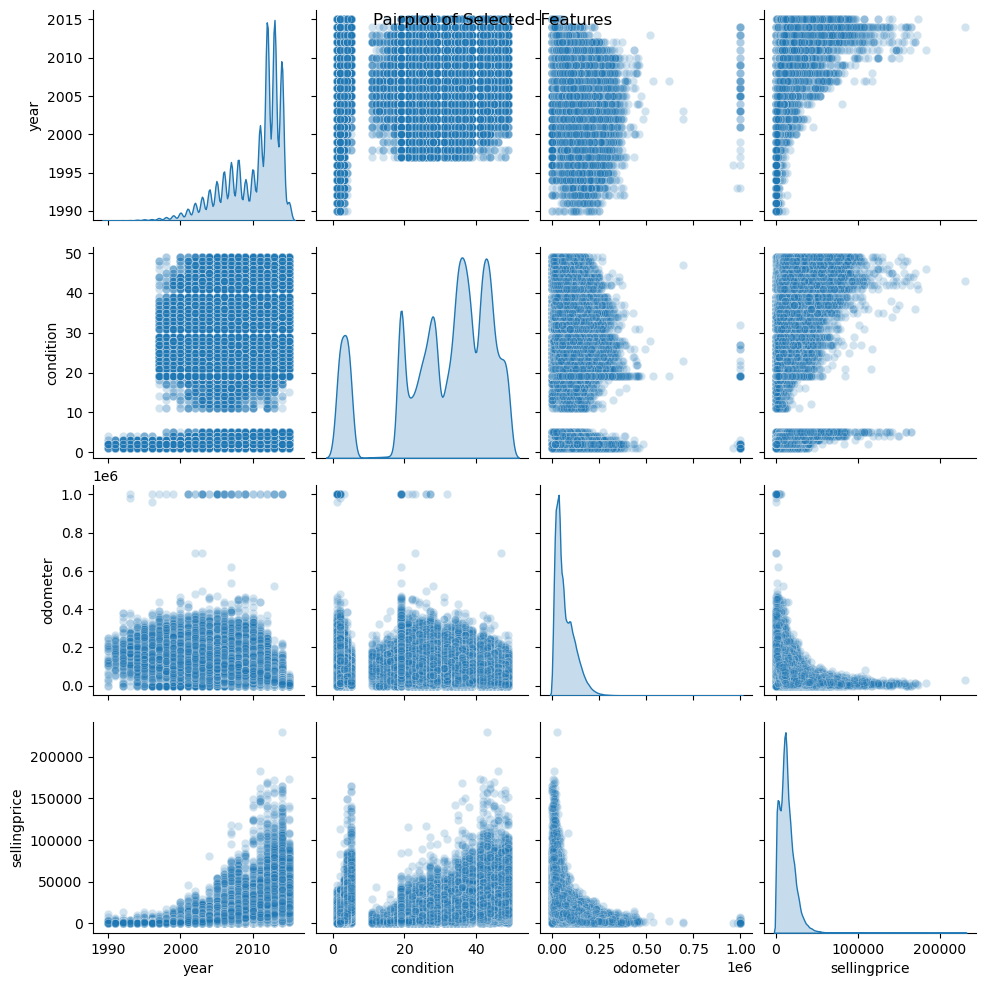

In [349]:
sns.pairplot(df[['year', 'condition', 'odometer', 'sellingprice']], diag_kind='kde', plot_kws={'alpha': 0.2})
plt.suptitle("Pairplot of Selected Features")
plt.show()

In [351]:
df = df.query('condition >= 10')
del df['saledate_parsed']
del df['saledate']
del df['saledate_year']
del df['trim']
del df['seller']

df = df.query('sellingprice < 35000 and odometer < 500000')

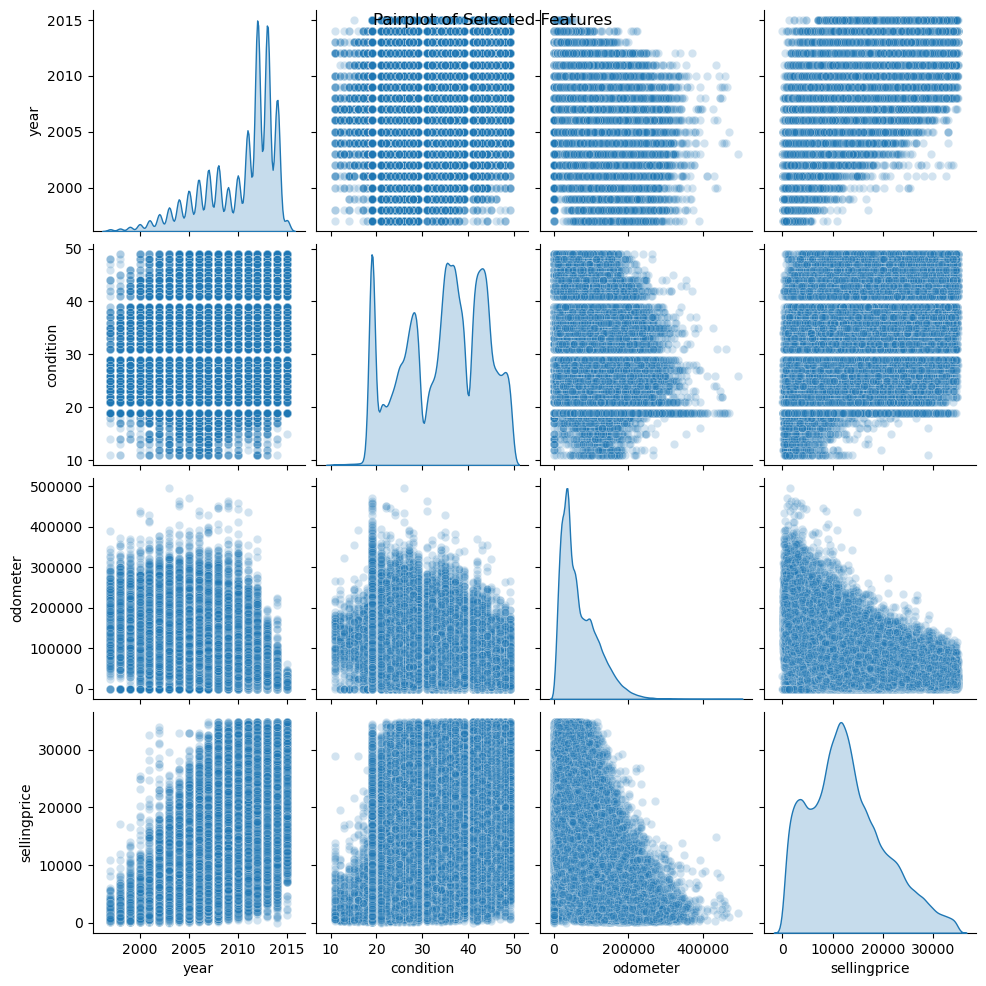

In [354]:
sns.pairplot(df[['year', 'condition', 'odometer', 'sellingprice']], diag_kind='kde', plot_kws={'alpha': 0.2})
plt.suptitle("Pairplot of Selected Features")
plt.show()

<br>

### 3. FE&ML: Without State

In [356]:
df_copy = df.copy()

<br>

### 3.1. Feature Engineering

In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401914 entries, 2 to 558836
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            401914 non-null  int64  
 1   make            401914 non-null  object 
 2   model           401914 non-null  object 
 3   body            401914 non-null  object 
 4   transmission    401914 non-null  object 
 5   state           401914 non-null  object 
 6   condition       401914 non-null  float64
 7   odometer        401914 non-null  float64
 8   color           401914 non-null  object 
 9   interior        401914 non-null  object 
 10  sellingprice    401914 non-null  float64
 11  saledate_month  401914 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 39.9+ MB


In [359]:
def one_hot_top_n(df, column, top_n=5):
    top_values = df[column].value_counts().head(top_n).index
    for value in top_values:
        df[f'{column}_{value}'] = (df[column] == value).astype(int)
    return df

In [360]:
del df['state']

categorical_columns = {
    'make':30,
    'model':40,
    # 'trim':20,
    'body':7,
    'transmission':1,
    # 'state':20,
    'color':6,
    'interior':4,
    # 'seller':20,
    'saledate_month':6
}

for col, value in categorical_columns.items():
    df = one_hot_top_n(df, col, top_n=value)

df = df.drop(columns=categorical_columns)

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401914 entries, 2 to 558836
Data columns (total 98 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   year                    401914 non-null  int64  
 1   condition               401914 non-null  float64
 2   odometer                401914 non-null  float64
 3   sellingprice            401914 non-null  float64
 4   make_Ford               401914 non-null  int64  
 5   make_Chevrolet          401914 non-null  int64  
 6   make_Nissan             401914 non-null  int64  
 7   make_Toyota             401914 non-null  int64  
 8   make_Honda              401914 non-null  int64  
 9   make_Dodge              401914 non-null  int64  
 10  make_Hyundai            401914 non-null  int64  
 11  make_Kia                401914 non-null  int64  
 12  make_BMW                401914 non-null  int64  
 13  make_Infiniti           401914 non-null  int64  
 14  make_Chrysler           4

<br>

### 3.2. Model Selection

In [371]:
df_sample = df# .sample(200_000, random_state=42)

X = df_sample.drop(columns=['sellingprice'])
y = df_sample['sellingprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [373]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# pca = PCA(n_components=0.80)
# pca.fit(X_train)

# X_train_pca = pca.transform(X_train)
# X_test_pca = pca.transform(X_test)

In [375]:
y_train.shape

(321531,)

<br>

### 3.2.1. Lasso

In [29]:
lasso = Lasso(max_iter=5000)

param_grid = {
    'alpha': np.logspace(-4, 3, 10)
}

lasso_grid_search = GridSearchCV(estimator=lasso, 
                                  param_grid=param_grid, 
                                  scoring='neg_mean_absolute_error', 
                                  cv=4, 
                                  verbose=1,
                                  n_jobs=-1)

lasso_grid_search.fit(X_train, y_train)
best_model = lasso_grid_search.best_estimator_
print("Best Parameters:", lasso_grid_search.best_params_)

print('Train MSE: ', mean_squared_error(y_train, best_model.predict(X_train)))
print('Test MSE: ',  mean_squared_error(y_test, best_model.predict(X_test)))

print('Train MAE: ', mean_absolute_error(y_train, best_model.predict(X_train)))
print('Test MAE: ',  mean_absolute_error(y_test, best_model.predict(X_test)))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Parameters: {'alpha': 0.774263682681127}
Train MSE:  11930491.285371162
Test MSE:  11912432.12430923
Train MAE:  2528.4830533764134
Test MAE:  2526.5514528496838


<br>

### 3.2.2. Ridge

In [31]:
ridge = Ridge(max_iter=5000)

param_grid = {
    'alpha': np.logspace(-4, 3, 10)
}
ridge_grid_search = GridSearchCV(estimator=ridge, 
                                 param_grid=param_grid, 
                                 scoring='neg_mean_absolute_error',
                                 cv=4, 
                                 verbose=1,
                                 n_jobs=-1)

ridge_grid_search.fit(X_train, y_train)
best_model = ridge_grid_search.best_estimator_
print("Best Parameters:", ridge_grid_search.best_params_)

print('Train MSE: ', mean_squared_error(y_train, best_model.predict(X_train)))
print('Test MSE: ',  mean_squared_error(y_test, best_model.predict(X_test)))

print('Train MAE: ', mean_absolute_error(y_train, best_model.predict(X_train)))
print('Test MAE: ',  mean_absolute_error(y_test, best_model.predict(X_test)))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Parameters: {'alpha': 1000.0}
Train MSE:  11931073.649749728
Test MSE:  11912968.93123116
Train MAE:  2528.2467258659335
Test MAE:  2526.352584701238


<br>

### 3.2.3. Decision Tree

In [33]:
dt = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [20,25,30],
    'min_samples_split': [15, 20, 25, 30],
    'min_samples_leaf': [15, 20, 25, 30],
    'max_features': [None, 'sqrt', 'log2'],
}

dt_grid_search = GridSearchCV(estimator=dt, 
                              param_grid=param_grid, 
                              scoring='neg_mean_absolute_error',
                              cv=4, 
                              verbose=1, 
                              n_jobs=-1)

dt_grid_search.fit(X_train, y_train)

best_model = dt_grid_search.best_estimator_
print("Best Parameters:", dt_grid_search.best_params_)

print('Train MSE: ', mean_squared_error(y_train, best_model.predict(X_train)))
print('Test MSE: ',  mean_squared_error(y_test, best_model.predict(X_test)))

print('Train MAE: ', mean_absolute_error(y_train, best_model.predict(X_train)))
print('Test MAE: ',  mean_absolute_error(y_test, best_model.predict(X_test)))

Fitting 4 folds for each of 144 candidates, totalling 576 fits
Best Parameters: {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 15}
Train MSE:  6787780.092485233
Test MSE:  8351531.363416852
Train MAE:  1727.5166594308448
Test MAE:  1930.391866972502


Feature Importances:
odometer: 0.4718
year: 0.1066
body_sedan: 0.0638
body_hatchback: 0.0441
condition: 0.0377
make_BMW: 0.0279
make_Mercedes-Benz: 0.0253
make_Lexus: 0.0245
body_crew cab: 0.0239
make_Infiniti: 0.0148
body_suv: 0.0128
model_F-150: 0.0115
make_Kia: 0.0097
make_Audi: 0.0070
model_Escape: 0.0069
make_Dodge: 0.0062
make_Lincoln: 0.0057
model_Rogue: 0.0056
make_Toyota: 0.0048
make_Cadillac: 0.0047
model_Explorer: 0.0045
interior_gray: 0.0037
body_wagon: 0.0036
make_Nissan: 0.0033
model_Equinox: 0.0032
make_Acura: 0.0031
model_Grand Cherokee: 0.0030
make_Jeep: 0.0030
model_Maxima: 0.0029
model_C-Class: 0.0025
model_Wrangler: 0.0024
make_Chevrolet: 0.0023
make_Hyundai: 0.0022
model_RAV4: 0.0022
model_300: 0.0021
model_Charger: 0.0019
interior_black: 0.0019
body_minivan: 0.0018
make_Subaru: 0.0018
make_Ford: 0.0016


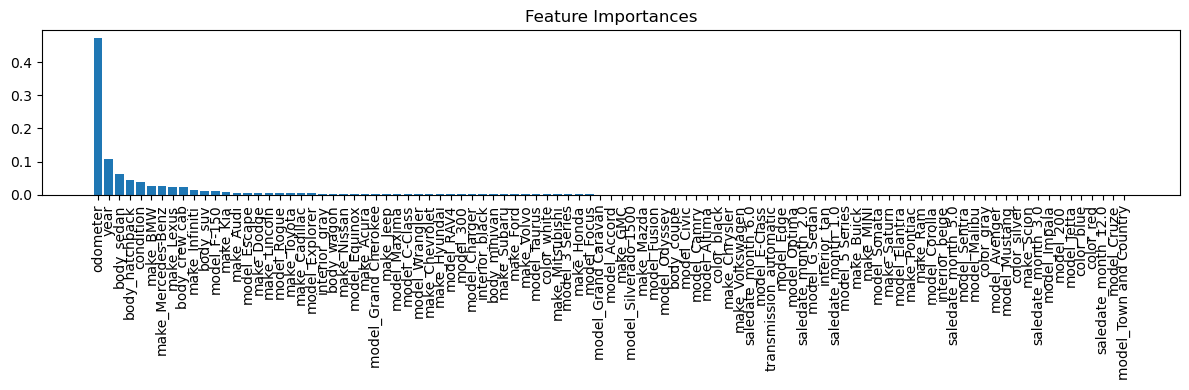

In [34]:
importances = best_model.feature_importances_
feature_names = X.columns

indices = np.argsort(importances)[::-1]

print("Feature Importances:")
for i in indices[:40]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

plt.figure(figsize=(12, 4))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

<br>

### 3.2.4. Random Forest

In [377]:
rf = RandomForestRegressor(random_state=42)

# {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 15}

param_grid = {
    'n_estimators': [30],
    'max_depth': [30],
    'min_samples_split': [15],
    'min_samples_leaf': [15],
    'max_features': [None],
}

rf_grid_search = GridSearchCV(estimator=rf, 
                              param_grid=param_grid, 
                              scoring='neg_mean_absolute_error',
                              cv=4, 
                              verbose=1, 
                              n_jobs=-1)

rf_grid_search.fit(X_train, y_train)

best_model = rf_grid_search.best_estimator_
print("Best Parameters:", rf_grid_search.best_params_)

print('Train MSE: ', mean_squared_error(y_train, best_model.predict(X_train)))
print('Test MSE: ',  mean_squared_error(y_test, best_model.predict(X_test)))

print('Train MAE: ', mean_absolute_error(y_train, best_model.predict(X_train)))
print('Test MAE: ',  mean_absolute_error(y_test, best_model.predict(X_test)))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best Parameters: {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 15, 'n_estimators': 30}
Train MSE:  6367384.6043859385
Test MSE:  7386047.297725635
Train MAE:  1672.7881872727119
Test MAE:  1809.2235417016436


In [378]:
print('Train MAPE: ', mean_absolute_percentage_error(y_train, best_model.predict(X_train)))
print('Test MAPE: ',  mean_absolute_percentage_error(y_test, best_model.predict(X_test)))

Train MAPE:  0.29571437192927014
Test MAPE:  0.21859252540504687


Feature Importances:
odometer: 0.4664
year: 0.1174
body_sedan: 0.0643
body_hatchback: 0.0437
condition: 0.0385
make_BMW: 0.0276
make_Mercedes-Benz: 0.0246
make_Lexus: 0.0244
body_crew cab: 0.0235
make_Infiniti: 0.0142
body_suv: 0.0124
model_F-150: 0.0109
make_Kia: 0.0096
model_Escape: 0.0071
make_Audi: 0.0067
make_Dodge: 0.0065
model_Rogue: 0.0060
make_Lincoln: 0.0055
make_Toyota: 0.0045
interior_gray: 0.0044


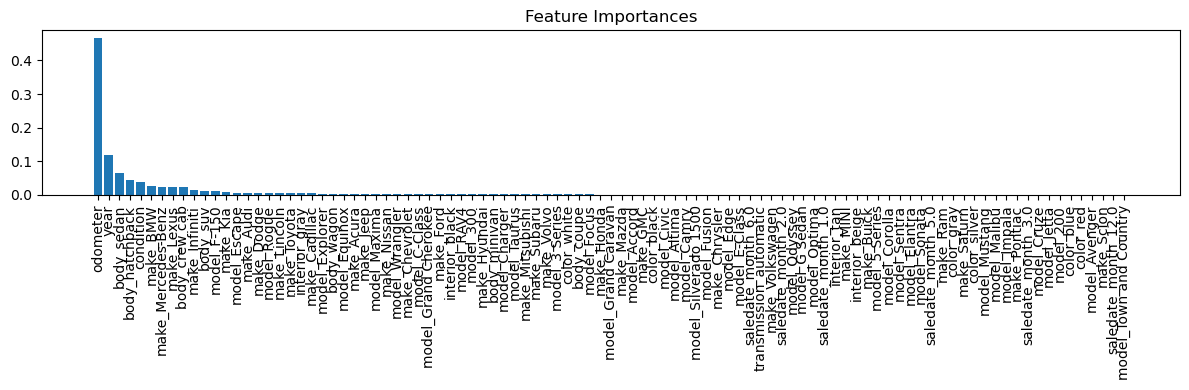

In [379]:
importances = best_model.feature_importances_
feature_names = X.columns

indices = np.argsort(importances)[::-1]

print("Feature Importances:")
for i in indices[:20]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

plt.figure(figsize=(12, 4))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

Test Data Residual Distribution


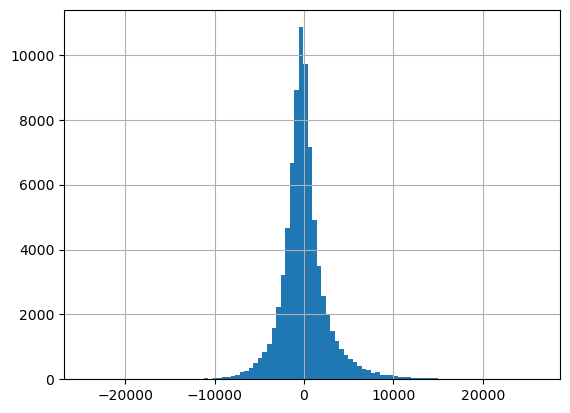

In [380]:
print('Test Data Residual Distribution')
plt.hist(y_test - best_model.predict(X_test), bins = 100)
plt.grid()
plt.show()

<br>

### 4. FE&ML: With State

In [230]:
df = df_copy.copy()

<br>

### 4.1. Feature Engineering

In [233]:
categorical_columns = {
    'make':30,
    'model':40,
    # 'trim':20,
    'body':7,
    'transmission':1,
    'state':20,
    'color':6,
    'interior':4,
    # 'seller':20,
    'saledate_month':6
}

for col, value in categorical_columns.items():
    df = one_hot_top_n(df, col, top_n=value)

df = df.drop(columns=categorical_columns)

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401914 entries, 2 to 558836
Columns: 118 entries, year to saledate_month_12.0
dtypes: float64(3), int64(115)
memory usage: 364.9 MB


<br>

### 4.2. Models

In [239]:
df_sample = df# .sample(200_000, random_state=42)

X = df_sample.drop(columns=['sellingprice'])
y = df_sample['sellingprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [241]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# pca = PCA(n_components=0.80)
# pca.fit(X_train)

# X_train_pca = pca.transform(X_train)
# X_test_pca = pca.transform(X_test)

In [242]:
y_train.shape

(321531,)

<br>

### 4.2.1. Desicion Tree

In [261]:
dt = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [20,25,30],
    'min_samples_split': [15, 20, 25, 30],
    'min_samples_leaf': [15, 20, 25, 30],
    'max_features': [None, 'sqrt', 'log2'],
}

dt_grid_search = GridSearchCV(estimator=dt, 
                              param_grid=param_grid, 
                              scoring='neg_mean_absolute_error',
                              cv=4, 
                              verbose=1, 
                              n_jobs=-1)

dt_grid_search.fit(X_train, y_train)

best_model = dt_grid_search.best_estimator_
print("Best Parameters:", dt_grid_search.best_params_)

print('Train MSE: ', mean_squared_error(y_train, best_model.predict(X_train)))
print('Test MSE: ',  mean_squared_error(y_test, best_model.predict(X_test)))

print('Train MAE: ', mean_absolute_error(y_train, best_model.predict(X_train)))
print('Test MAE: ',  mean_absolute_error(y_test, best_model.predict(X_test)))

Fitting 4 folds for each of 144 candidates, totalling 576 fits
Best Parameters: {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 15}
Train MSE:  6761153.16317025
Test MSE:  8368310.600072485
Train MAE:  1724.6972063771245
Test MAE:  1931.8367709343981


Feature Importances:
odometer: 0.4713
year: 0.1064
body_sedan: 0.0638
body_hatchback: 0.0440
condition: 0.0374
make_BMW: 0.0279
make_Mercedes-Benz: 0.0253
make_Lexus: 0.0245
body_crew cab: 0.0239
make_Infiniti: 0.0148
body_suv: 0.0128
model_F-150: 0.0115
make_Kia: 0.0097
make_Audi: 0.0070
model_Escape: 0.0069
make_Dodge: 0.0062
make_Lincoln: 0.0057
model_Rogue: 0.0056
make_Toyota: 0.0048
make_Cadillac: 0.0047


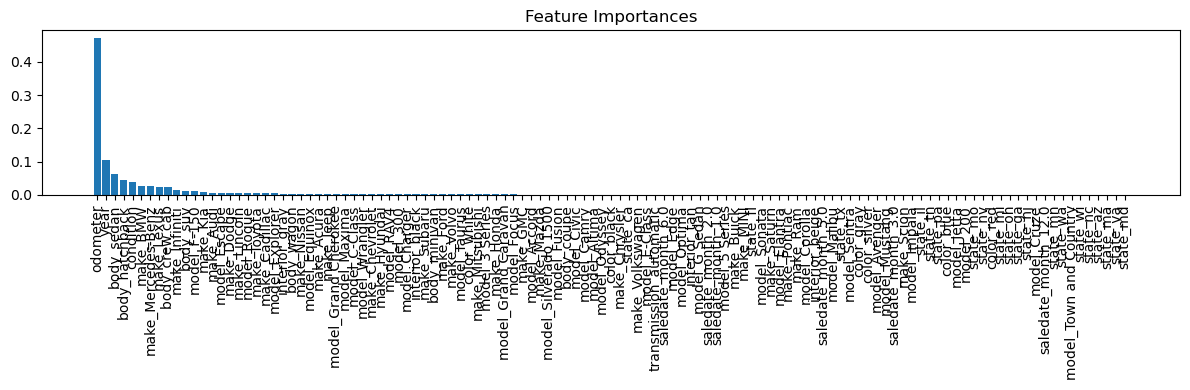

In [262]:
importances = best_model.feature_importances_
feature_names = X.columns

indices = np.argsort(importances)[::-1]

print("Feature Importances:")
for i in indices[:20]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

plt.figure(figsize=(12, 4))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

<br>

### 5. Results

* Lasso and Ridge produced similar results.
* The results of Decision Tree was better than of Lasso and Ridge.
* Based of the parameters of Decision Tree, Random Forest was built, showng the best results.
* Data with and without US states showed similar results, meaning the states are not important in price forming.
* Top 1 important metric in price forming is odometer (with 47% of importance), the 2nd one is year of production (10%). body_sedan, body_hatchback and condition are also relatively important. All other metrics has importance lower than 3%.

<br>

### 6. Recommendations

* Use Random Forest model without states as the final model to predict car price.
* Use the predictions as the baseline and adjust car price according to such info as photos and so on.